In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!unzip '/content/data_augmentation.zip'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data_augmentation/FACE/1144.jpg_aug_169.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_17.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_18.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_19.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_2.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_20.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_21.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_22.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_23.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_24.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_25.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_26.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_27.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_28.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_29.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_3.j

In [ ]:
def split_data(data_dir):
    batch_size = 32
    img_height = 224
    img_width = 224

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    class_names = np.array(train_ds.class_names)

    normalization_layer = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    return class_names,train_ds,val_ds

In [ ]:
class_names,x_train,  x_valid   =split_data('../content/data_augmentation/' )

Found 8690 files belonging to 49 classes.
Using 6952 files for training.
Found 8690 files belonging to 49 classes.
Using 1738 files for validation.


In [ ]:
for image_batch, labels_batch in x_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/best_model_CNN.keras",
        monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)
history = model.fit(
    x_train,
    validation_data=x_valid,
    epochs=50,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]

)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0848 - loss: 3.9162
Epoch 1: val_accuracy improved from -inf to 0.56502, saving model to ../weights/best_model_CNN.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 793s 4s/step - accuracy: 0.0853 - loss: 3.9128 - val_accuracy: 0.5650 - val_loss: 1.5124 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5021 - loss: 1.6298
Epoch 2: val_accuracy improved from 0.56502 to 0.80495, saving model to ../weights/best_model_CNN.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 765s 3s/step - accuracy: 0.5024 - loss: 1.6287 - val_accuracy: 0.8049 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7285 - loss: 0.8510
Epoch 3: val_accuracy improved from 0.80495 to 0.84120, saving model to ../weights/best_model_CNN.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.7286 - loss: 0.8506 - val_accuracy: 0.8412 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 4/50

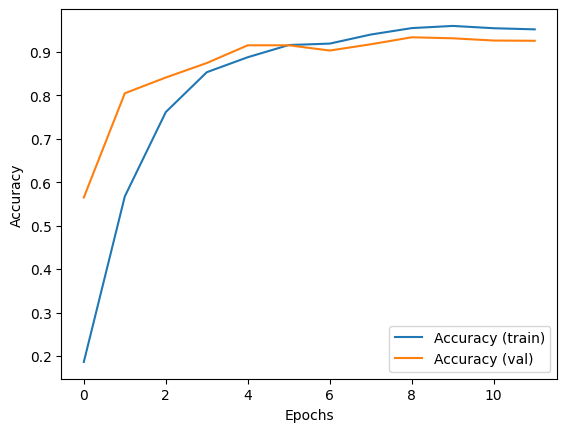

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_valid, verbose=2)
print(f"Test accuracy: {test_acc}")

55/55 - 51s - 926ms/step - accuracy: 0.9338 - loss: 0.1906
Test accuracy: 0.9338319897651672


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 49)                  │           3,185 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,405,461 (127.43 MB)

 Trainable params: 11,135,153 (42.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,270,308 (84.95 MB)